In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt,floor
from heapq import nlargest 
from sklearn. metrics import classification_report,auc, roc_curve, accuracy_score
import weka.core.converters as converter
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.core.jvm as jvm
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import cross_val_score


pd.options.mode.chained_assignment = None


def impute_transform(imputer,X):
    X_array=imputer.transform(X)
    X_imputed=pd.DataFrame(X_array, columns = X.columns)
    return X_imputed

def replace_data(df1):
    df_replaced = df1
    df_replaced = df_replaced.replace('neg',0)
    df_replaced = df_replaced.replace('pos',1)
    return df_replaced

 
def impute_data(df,replacement,target,reg,split):
    df.replace(replacement,np.nan,inplace=True)
    df_X = df.drop(target,axis=1)
    df_y = df[target]
    if reg:
        X_train,X_test,y_train, y_test = df_X[:split], df_X[split:], df_y[:split],df_y[split:]
        simple_imputer=SimpleImputer(missing_values=np.nan,strategy='mean').fit(X_train)
        X_train_imputed = impute_transform(simple_imputer,X_train)                
        X_test_imputed = impute_transform(simple_imputer,X_test)
        return X_train_imputed,X_test_imputed,y_train, y_test
    else:

        imputer=SimpleImputer(missing_values=np.nan,strategy='mean').fit(df_X)
        X_imputed_df = impute_transform(imputer,df_X)
        X_train,X_test,y_train, y_test = X_imputed_df[:split], X_imputed_df[split:], df_y[:split],df_y[split:]
        return X_train,X_test,y_train, y_test
def get_corr_matrix(df_corr):
    corrMatrix = df_corr.corr()
    #print(corrMatrix)
    fig = plt.figure(figsize=(20, 15))
    sns.heatmap(corrMatrix)
    plt.show()

def calculate_CV(df):
    CV = {}
    Col_Name=[]
    df_SD=df.std(axis = 0)
    df_mean = df.mean(axis = 0)
    for columnName in df:
        col= columnName
        Col_Name.append(col)
    for i in range(0,len(df.columns)):
        CV[i] = df_SD[i]/df_mean[i]
    no_of_columns = floor(sqrt(len(df.columns)))
    Selected_Values = []
    NLarge = nlargest(no_of_columns, CV, key = CV.get) 
  
    for val in NLarge: 
        Selected_Values.append(Col_Name[val])
    return Selected_Values

def plot_roc_curve(fpr, tpr,train_test):
    #print("ROC CURVE")
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for {}'.format(train_test))
    plt.legend()
    plt.show()

def get_class_metrics(predictions,y,train_test):
    print('Classification Report {}'.format(train_test))
    print(classification_report(y,predictions))
    print('------------------------------------------------')
    print('Accuracy Score')
    print(accuracy_score(y,predictions))
    print('------------------------------------------------')
    y_replaced = replace_data(y)
    predictions_replaced = replace_data(pd.Series(predictions))
    falsePositiveRate, truePositiveRate, thresholds = roc_curve(y_replaced, predictions_replaced)
    area = auc(falsePositiveRate, truePositiveRate)
    plot_roc_curve(falsePositiveRate,truePositiveRate,train_test)
    return accuracy_score(y,predictions)

def run_weka(train_path,test_path,X_train,y_train,X_test,y_test,smote=False):
    if jvm.started:
        x1=1
    else:
        jvm.start(max_heap_size="2048m")
    if smote:
        smote_model = SMOTE(random_state=2333)
        smote_fit = smote_model.fit_sample(X_train,y_train)
        X_train = pd.DataFrame(smote_fit[0])
        y_train = pd.DataFrame(smote_fit[1], columns=['class'])
    export_data = pd.concat([y_train,X_train],axis=1)
    export_data.to_csv(train_path, sep=',', index=False)
    data = converter.load_any_file(filename=train_path)
    data.class_is_first()
    
    log_tree = Classifier(classname="weka.classifiers.trees.LMT")
    eval_obj = Evaluation(data)
    eval_obj.crossvalidate_model(classifier=log_tree, data=data, 
                                   num_folds=5, rnd=Random(1))
    print("---- Train -----")
    print(eval_obj.matrix())
    print("----- Summary -----")
    print(eval_obj.summary())
    
    log_tree.build_classifier(data)
    y_predict = eval_obj.test_model(log_tree,data)
    
    y_train_replaced = y_train.copy()
    y_train_replaced.replace('neg',0,inplace=True)
    y_train_replaced.replace('pos',1,inplace=True)
    train_metrics = get_class_metrics(y_predict,y_train_replaced,'train')
    
    
    export_test_data = pd.concat([y_test,X_test],axis=1)
    export_test_data.to_csv(test_path, sep=',', index=False)
    test_data = converter.load_any_file(filename=test_path)
    test_data.class_is_first()
    y_pred_test = eval_obj.test_model(log_tree,test_data)
    
    y_test_replaced = y_test.copy()
    y_test_replaced.replace('neg',0,inplace=True)
    y_test_replaced.replace('pos',1,inplace=True)
    
    test_metrics = get_class_metrics(y_pred_test,y_test_replaced,'tests')
    #return weka_metrics

## 1 a

In [14]:
df_reg=pd.read_csv(r'communities.csv')

## 1 b

In [57]:
df_reg.drop(['state','county','community','communityname','fold'],axis=1,inplace=True)
X_train_reg,X_test_reg,y_train_reg,y_test_reg = impute_data(df_reg,'?','ViolentCrimesPerPop',True,1495)

## 1 c

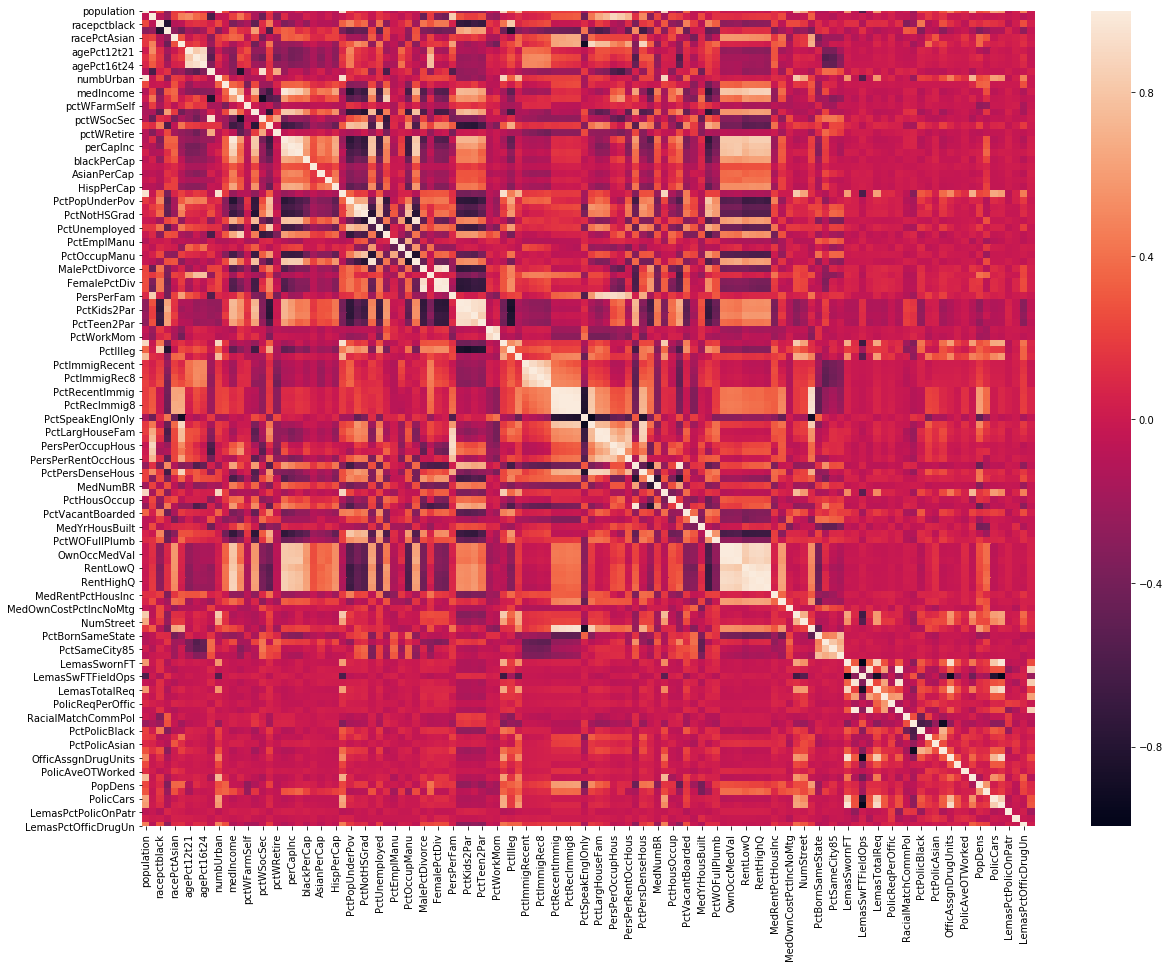

In [58]:
get_corr_matrix(X_train_reg)

## 1 d and 1 e

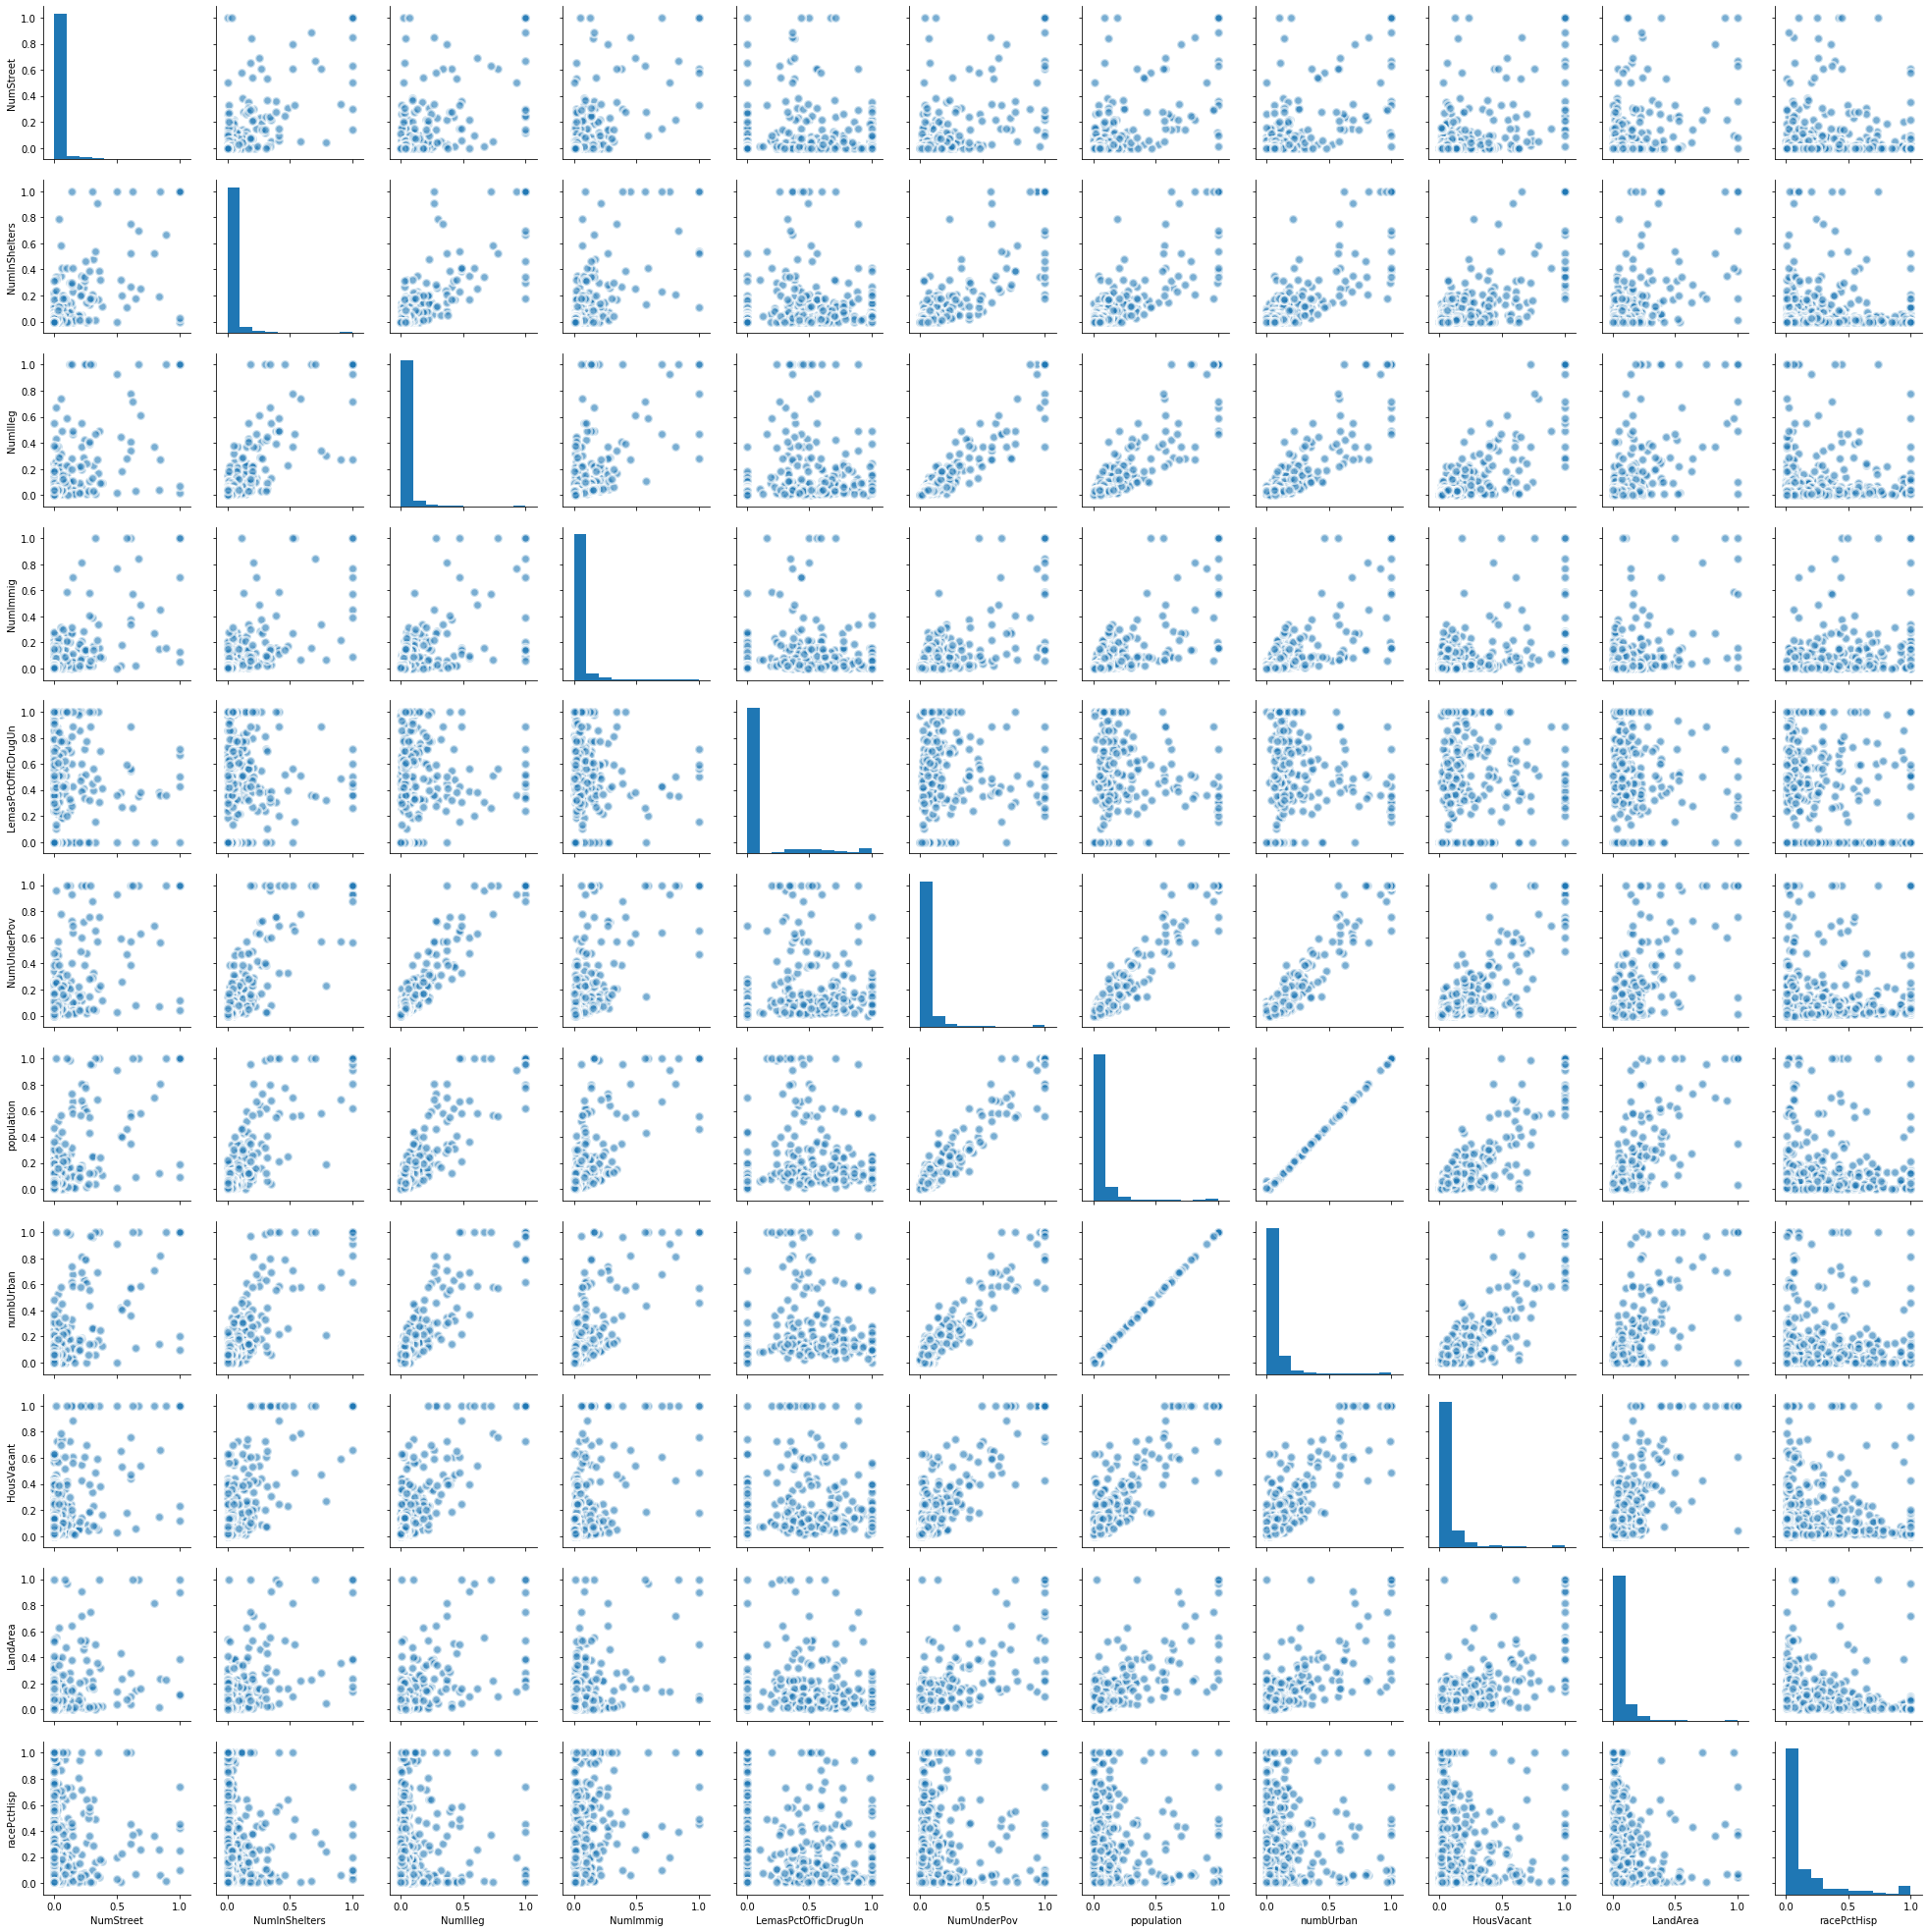

In [5]:
CV_reg_feature_list = calculate_CV(X_train_reg)
sns.pairplot(X_train_reg[CV_reg_feature_list], plot_kws=dict(s=80, edgecolor="white", linewidth=2.5, alpha=0.6))
plt.show()

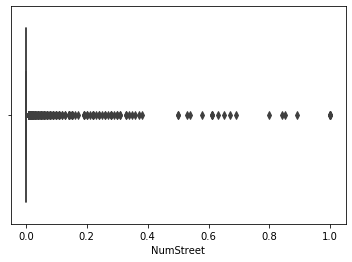

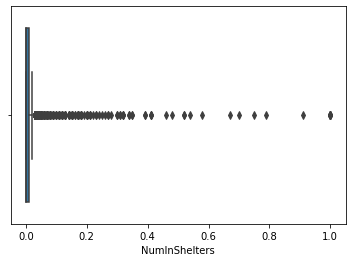

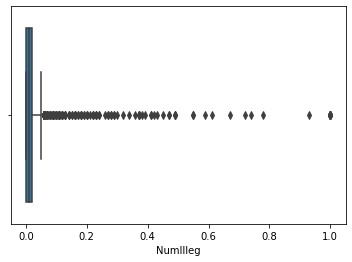

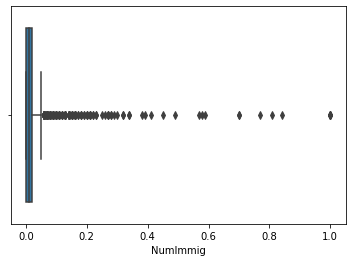

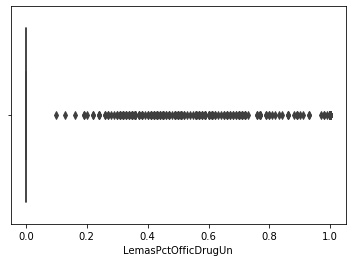

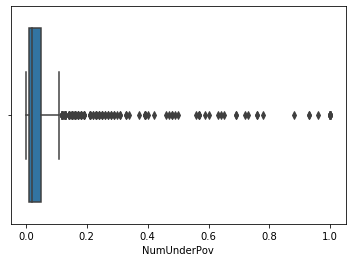

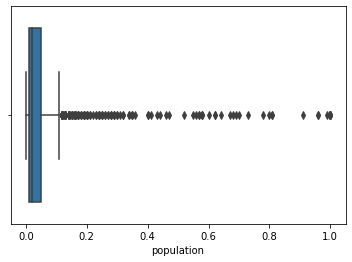

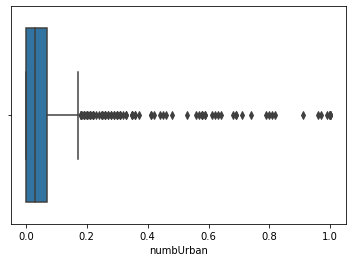

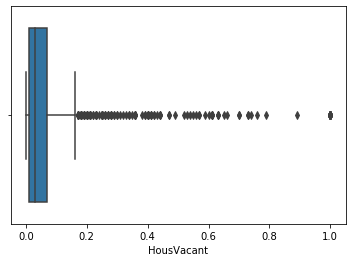

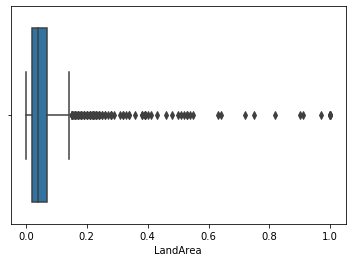

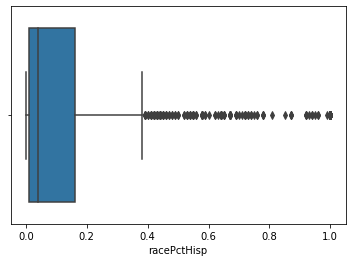

In [6]:
for val in CV_reg_feature_list:
    ax = sns.boxplot(x=X_train_reg[val])
    plt.show()

## 1 f

In [59]:
linReg = LinearRegression().fit(X_train_reg, y_train_reg)
y_reg_predict = linReg.predict(X_test_reg)
print("Mean Square Error : ", mean_squared_error(y_test_reg, y_reg_predict))
print("R2 Score : ", linReg.score(X_train_reg, y_train_reg))

Mean Square Error :  0.01814197113553011
R2 Score :  0.7111486198097661


## 1 g

In [60]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train_reg, y_train_reg)
print("RidgeCV alpha",ridgecv.alpha_)

ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train_reg, y_train_reg)
print("Ridge MSE :",mean_squared_error(y_test_reg, ridge.predict(X_test_reg)))

RidgeCV alpha 0.0466301673441609
Ridge MSE : 0.017559391339081944


## 1 h

In [62]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_selection import SelectFromModel

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train_reg, y_train_reg)
print('Lasso Alpha :',lassocv.alpha_)
lasso = Lasso(max_iter = 10000, normalize = True,alpha = lassocv.alpha_).fit(X_train_reg,y_train_reg)
print('Lasso MSE : ',mean_squared_error(y_test_reg, lasso.predict(X_test_reg)))
    
s_scalar = StandardScaler().fit_transform(X_train_reg)
X_train_reg_standard = pd.DataFrame(s_scalar,columns=X_train_reg.columns)

lasso_standard = Lasso(max_iter = 10000, normalize = True,alpha = lassocv.alpha_).fit(X_train_reg_standard,y_train_reg)
print('Lasso Standerdized MSE : ',mean_squared_error(y_test_reg, lasso_standard.predict(X_test_reg)))

Lasso Alpha : 1.840553189634884e-05
Lasso MSE :  0.01782160314223624
Lasso Standerdized MSE :  0.035502730942602645


In [63]:
coef_dict = {}
for coef, feat in zip(lasso.coef_,list(X_train_reg.columns)):
    coef_dict[feat] = coef
{k:v for (k,v) in coef_dict.items() if v > 0}

{'racepctblack': 0.2670026192108806,
 'agePct12t21': 0.07240985064440189,
 'pctUrban': 0.03768429389517376,
 'pctWFarmSelf': 0.021471099119872328,
 'pctWSocSec': 0.054723905425204965,
 'pctWPubAsst': 0.029359732246364477,
 'AsianPerCap': 0.02685097511084318,
 'OtherPerCap': 0.02053789330003086,
 'HispPerCap': 0.022454254686015068,
 'PctEmploy': 0.1301342676664141,
 'MalePctDivorce': 0.10796828437780362,
 'MalePctNevMarr': 0.12558550628211534,
 'PctIlleg': 0.10583387445907762,
 'PctRecImmig10': 0.031045491101011125,
 'PersPerOccupHous': 0.03297753945558951,
 'PctPersDenseHous': 0.1977888287183722,
 'PctHousLess3BR': 0.058400791685952684,
 'MedNumBR': 0.0008119891056915557,
 'HousVacant': 0.11682744021091127,
 'PctVacantBoarded': 0.06883059228255649,
 'PctHousNoPhone': 0.011165032739300088,
 'MedRent': 0.12906892035951353,
 'MedRentPctHousInc': 0.09031400292451049,
 'NumInShelters': 0.07172795442487521,
 'NumStreet': 0.1850981043873623,
 'PctForeignBorn': 0.02900859782032905,
 'PctSameCi

## 1 i

In [64]:
MSE_list =[]
LR = LinearRegression()
for M in range(1,123):
    pca = PCA(n_components=M)
    X_train_st = StandardScaler().fit_transform(X_train_reg)
    X = pca.fit_transform(X_train_st)
    score = -1*cross_val_score(LR, X, y_train_reg, cv=10, scoring='neg_mean_squared_error').mean()
    MSE_list.append(score)
    
pca = PCA(n_components=MSE_list.index(min(MSE_list))+1)
X_train_reg_pca = pca.fit_transform(X_train_reg_standard)
X_test_reg_standard = StandardScaler().fit_transform(X_test_reg)
X_test_reg_pca = pca.fit_transform(X_test_reg_standard)
lin_reg_pca = LinearRegression().fit(X_train_reg_pca, y_train_reg)
y_predict_reg_pca = lin_reg_pca.predict(X_test_reg_pca)
print("PCA MSE : ",mean_squared_error(y_test_reg, y_predict_reg_pca))

PCA MSE :  0.04540011577939726


# 1 j

In [65]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xg_reg = xgb.XGBRegressor(objective ="reg:squarederror",max_depth = 5, n_estimators = 100)
params = {'alpha': [i for i in np.arange(0.001,0.10,0.001)]}
xgb_rscv = RandomizedSearchCV(xg_reg, param_distributions = params,cv = 10).fit(X_train_reg, y_train_reg)
print("XGBoost Alpha: ", xgb_rscv.best_params_)

XGBoost Alpha:  {'alpha': 0.035}


## 2 a

In [2]:
train_class = pd.read_csv(r'C:\Users\saija\Downloads\supriya\HW4\aps_failure_training_set.csv')
test_class = pd.read_csv(r'C:\Users\saija\Downloads\supriya\HW4\aps_failure_test_set.csv')
df_class = pd.concat([train_class,test_class])

## 2 (b) i

In [3]:
X_train_class,X_test_class,y_train_class,y_test_class = impute_data(df_class,'na','class',False,60000)
#X_train_class,X_test_class,y_train_class,y_test_class = X_train_class[:1000],X_test_class[:1000],y_train_class[:1000],y_test_class[:1000]
X_test_class.reset_index(inplace=True)
X_test_class.drop('index',axis=1,inplace=True)

## 2 (b) ii 

In [30]:
CV_class_feature_list = calculate_CV(X_train_class)


## 2 (b) iii

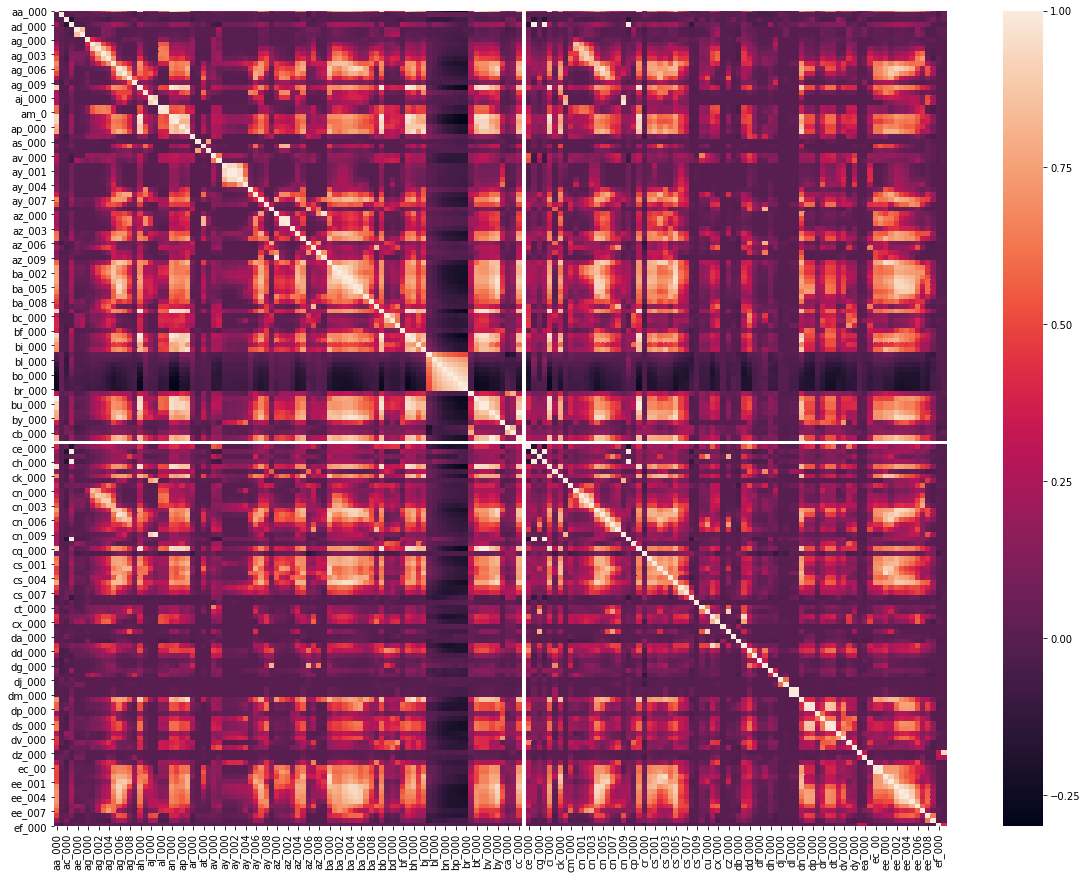

In [31]:
get_corr_matrix(X_train_class)

##  2 (b) iv

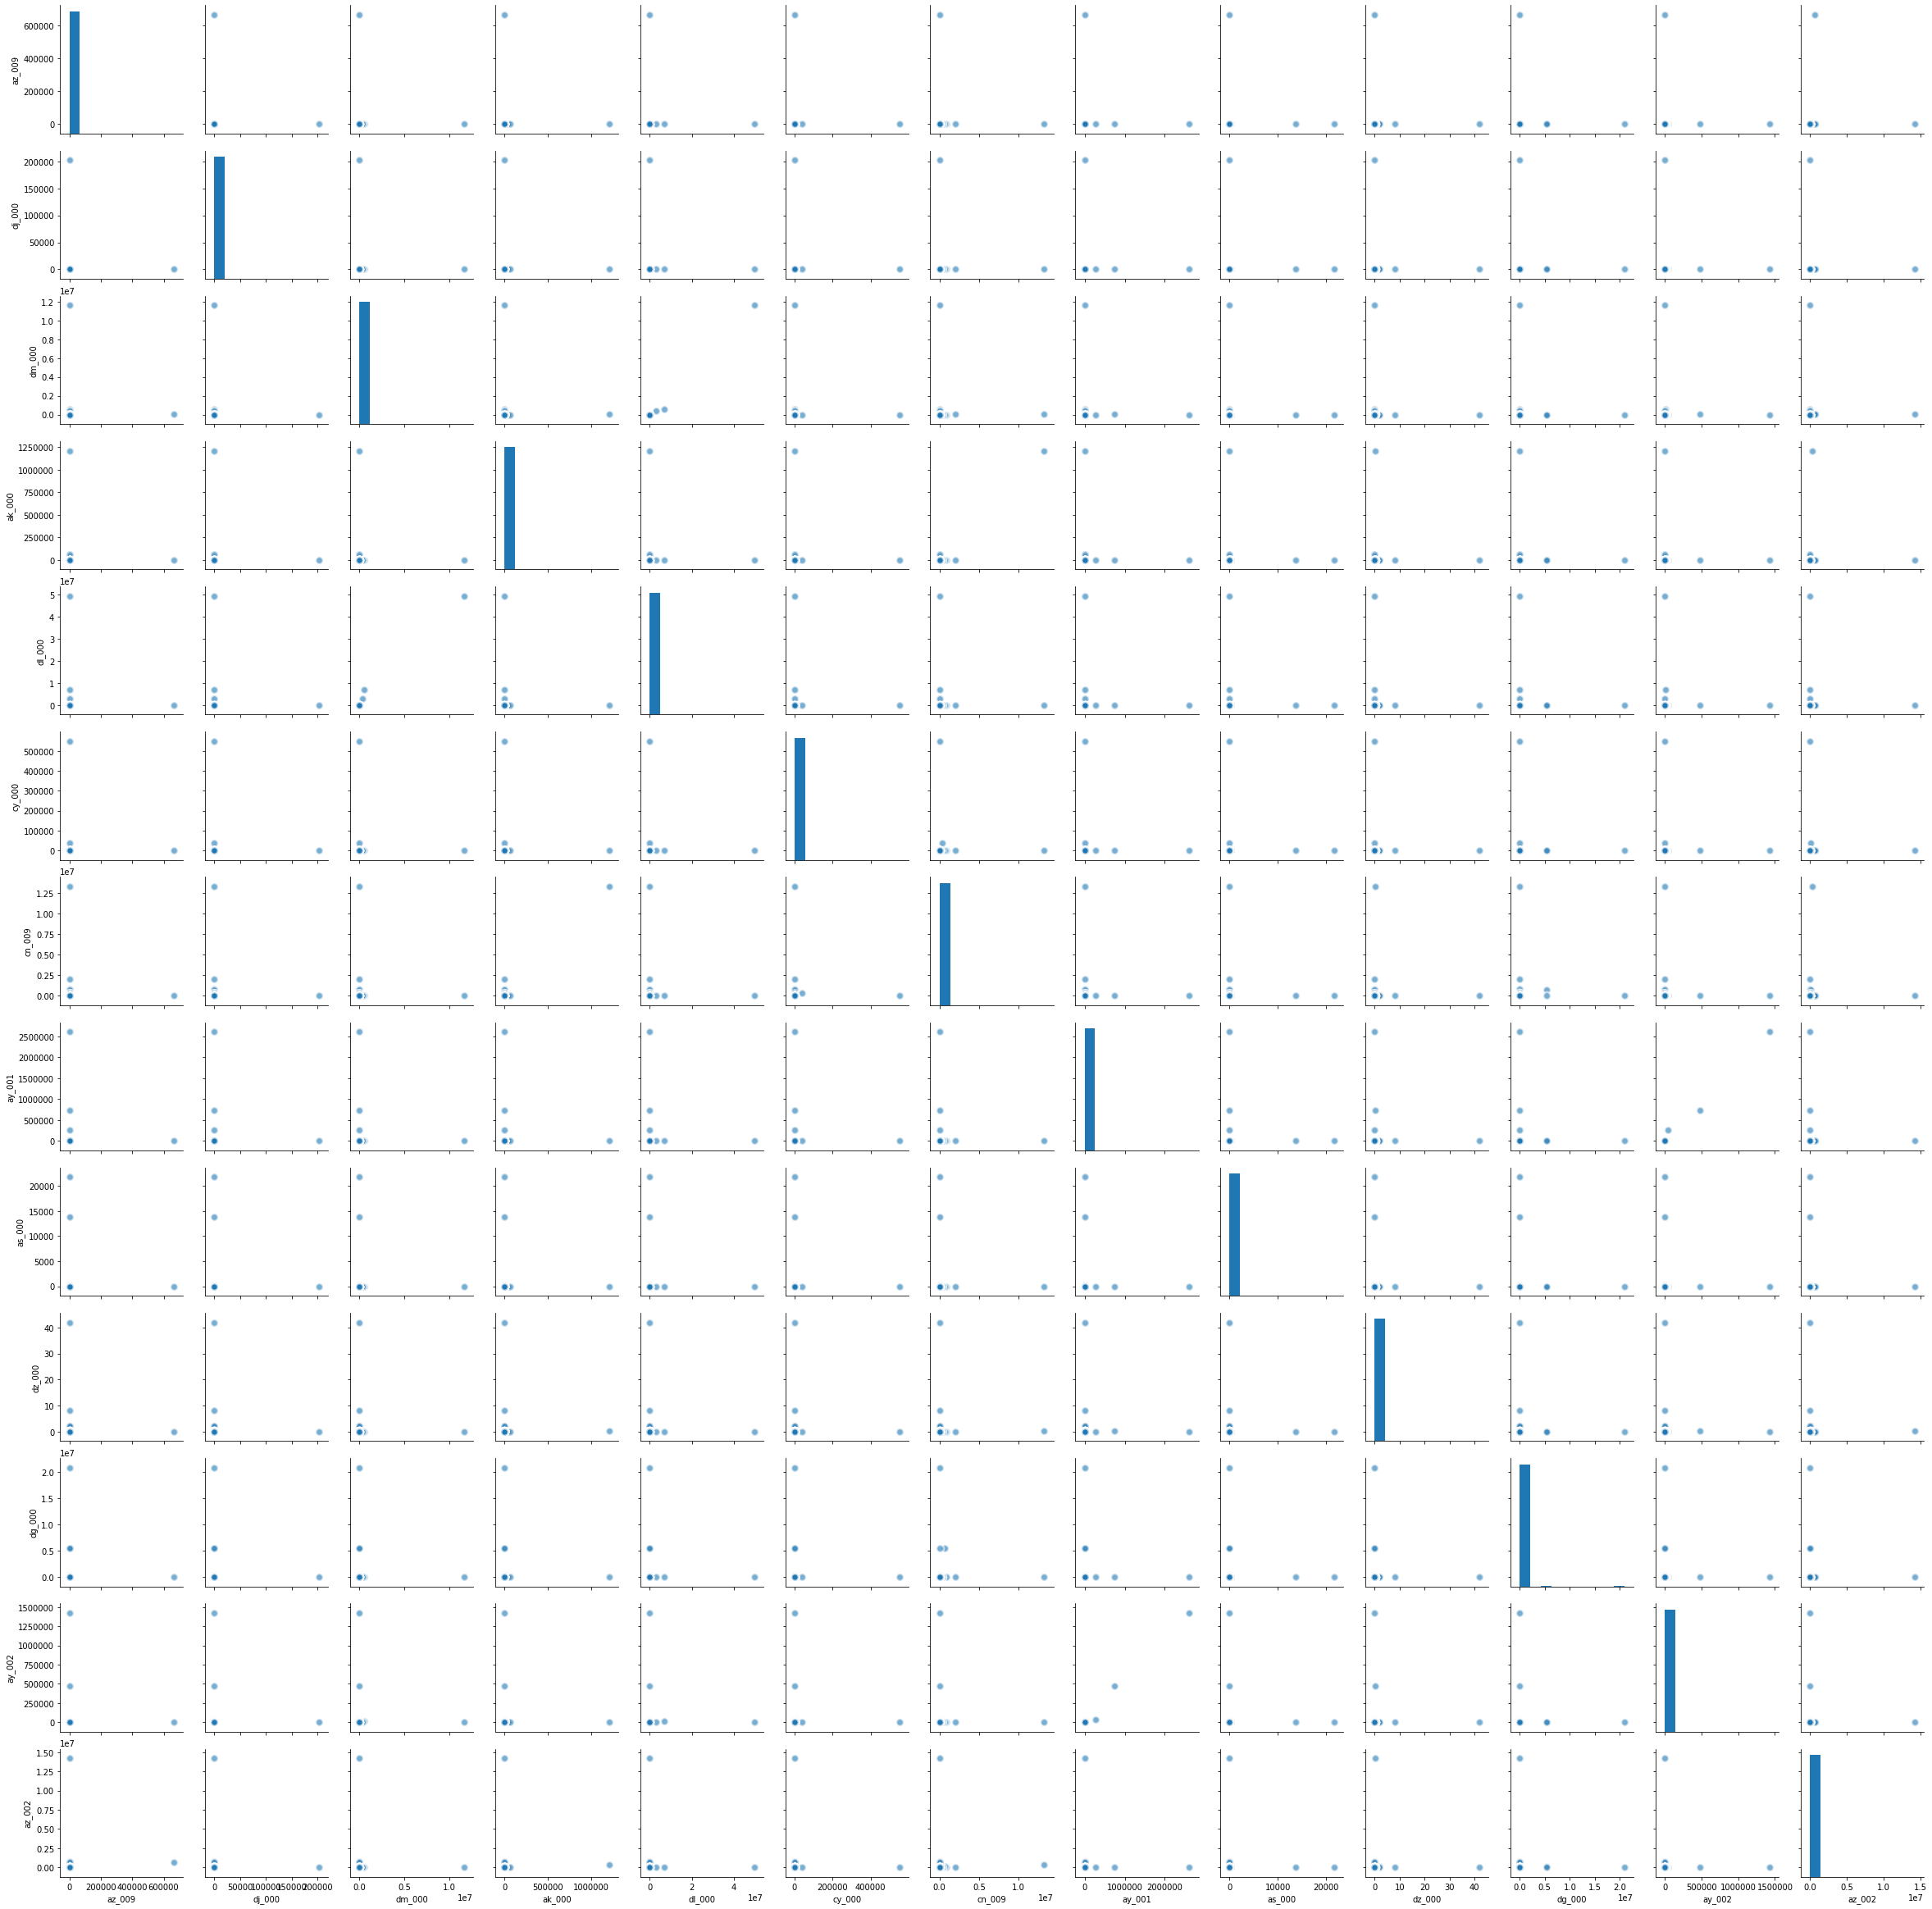

In [33]:
sns.pairplot(X_train_class[CV_class_feature_list], plot_kws=dict(s=80, edgecolor="white", linewidth=2.5, alpha=0.6))
plt.show()

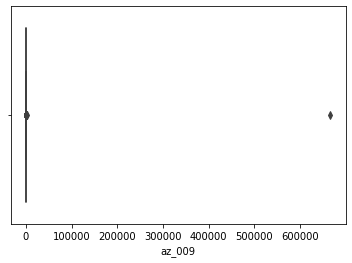

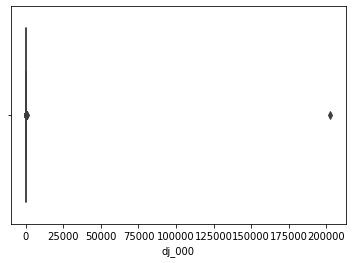

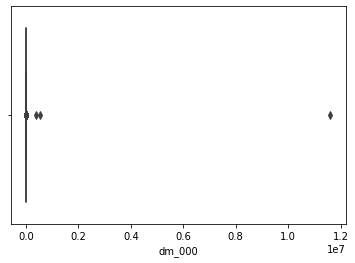

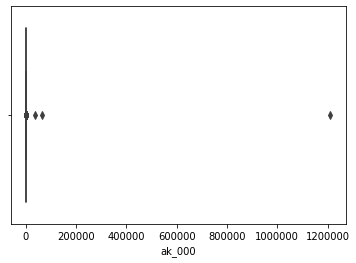

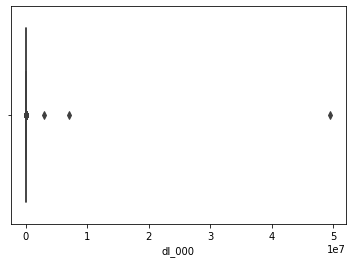

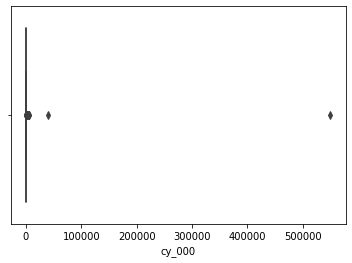

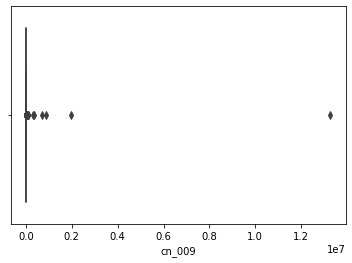

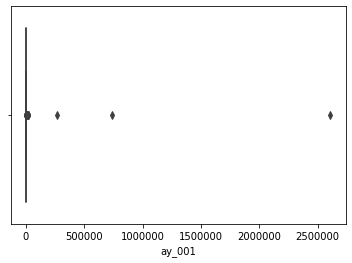

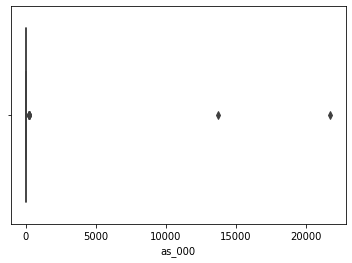

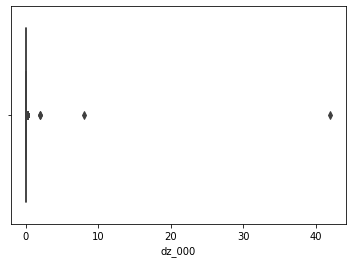

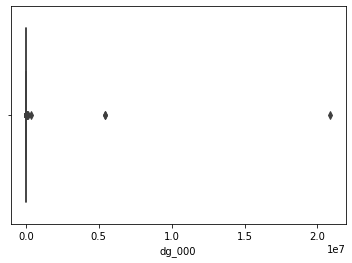

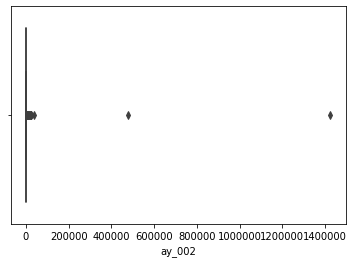

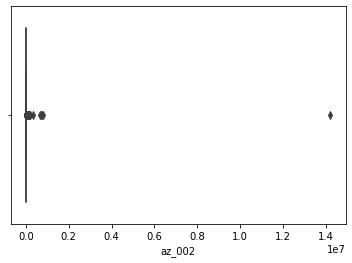

In [34]:
for val in CV_class_feature_list:
    ax = sns.boxplot(x=X_train_class[val])
    plt.show()

## 2 (b) v

In [35]:
y_train_class.value_counts()

neg    975
pos     25
Name: class, dtype: int64

## 2 (c)

--------Train-----------------------------------------------------
Classification Report Train Random Forest
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     59000
         pos       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

------------------------------------------------
Accuracy Score
1.0
------------------------------------------------


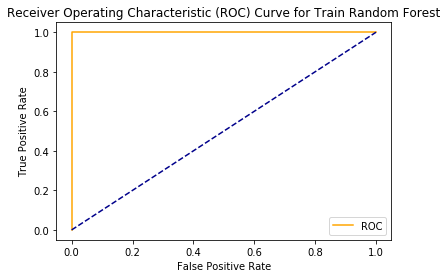

--------Test------------------------------------------------------
Classification Report Test Random Forest
              precision    recall  f1-score   support

         neg       0.99      1.00      1.00     15625
         pos       0.94      0.70      0.80       375

    accuracy                           0.99     16000
   macro avg       0.97      0.85      0.90     16000
weighted avg       0.99      0.99      0.99     16000

------------------------------------------------
Accuracy Score
0.991875
------------------------------------------------


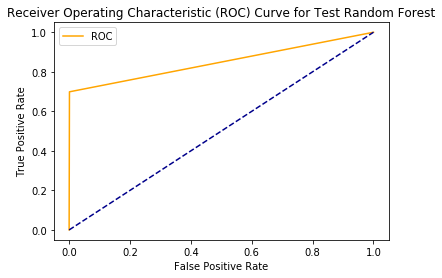

In [18]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(oob_score=True,n_estimators = 100).fit(X_train_class,y_train_class)
y_class_predict_train = random_forest.predict(X_train_class)
print('--------Train-----------------------------------------------------')
train_accuracy = get_class_metrics(y_class_predict_train,y_train_class,'Train Random Forest')
print('--------Test------------------------------------------------------')
y_class_predict_test = random_forest.predict(X_test_class)
test_accuracy = get_class_metrics(y_class_predict_test,y_test_class,'Test Random Forest')

In [19]:
print(random_forest.oob_score_)
print(test_accuracy)

0.99405
0.991875


## 2 (d)

------------Random Forest on Balanced Data-----------
--------Train-----------------------------------------------------
Classification Report Train Random Forest Balanced
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00     59000
         pos       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

------------------------------------------------
Accuracy Score
1.0
------------------------------------------------


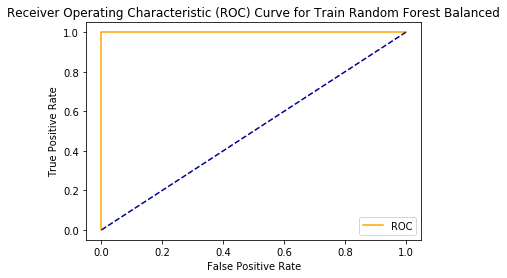

--------Test-----------------------------------------------------
Classification Report Test Random Forest Balanced
              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     15625
         pos       0.93      0.58      0.71       375

    accuracy                           0.99     16000
   macro avg       0.96      0.79      0.85     16000
weighted avg       0.99      0.99      0.99     16000

------------------------------------------------
Accuracy Score
0.989125
------------------------------------------------


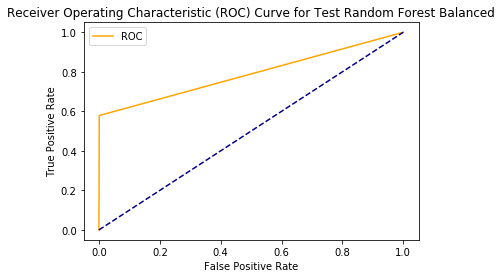

In [20]:
random_forest_balanced = RandomForestClassifier(oob_score=True,n_estimators=100,class_weight='balanced').fit(X_train_class,y_train_class)
y_class_predict_train_balanced = random_forest_balanced.predict(X_train_class)
print('------------Random Forest on Balanced Data-----------')
print('--------Train-----------------------------------------------------')
train_accuracy_balanced = get_class_metrics(y_class_predict_train_balanced,y_train_class,'Train Random Forest Balanced')
print('--------Test-----------------------------------------------------')
y_class_predict_test_balanced =  random_forest_balanced.predict(X_test_class)
test_accuracy_balanced = get_class_metrics(y_class_predict_test_balanced,y_test_class,'Test Random Forest Balanced')

In [21]:
print(random_forest_balanced.oob_score_)
print(test_accuracy_balanced)

0.99195
0.989125


## 2 (e)

---- Train -----
=== Confusion Matrix ===

     a     b   <-- classified as
 58855   145 |     a = neg
   347   653 |     b = pos

----- Summary -----

Correctly Classified Instances       59508               99.18   %
Incorrectly Classified Instances       492                0.82   %
Kappa statistic                          0.7223
Mean absolute error                      0.0118
Root mean squared error                  0.082 
Relative absolute error                 36.0337 %
Root relative squared error             64.0674 %
Total Number of Instances            60000     

Classification Report train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.92      0.74      0.82      1000

    accuracy                           0.99     60000
   macro avg       0.96      0.87      0.91     60000
weighted avg       0.99      0.99      0.99     60000

------------------------------------------------
Accuracy Score
0.

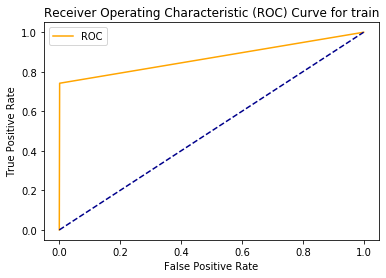

Classification Report tests
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.85      0.72      0.78       375

    accuracy                           0.99     16000
   macro avg       0.92      0.86      0.89     16000
weighted avg       0.99      0.99      0.99     16000

------------------------------------------------
Accuracy Score
0.990375
------------------------------------------------


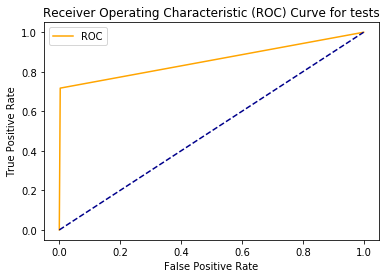

In [22]:
run_weka('./weka_train_data.csv','./weka_test_data.csv',X_train_class,y_train_class,X_test_class,y_test_class)

## 2 (f)

C:\Users\saija\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\saija\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\saija\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\saija\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\cpython.jar', 'C:\\Users\\saija\\Anaconda3\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'C:\\Users\\saija\\Anaconda3\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=2048m
DEBUG:weka.core.jvm:Package support disabled


Classification Report train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     59000
           1       0.76      0.94      0.84      1000

    accuracy                           0.99     60000
   macro avg       0.88      0.97      0.92     60000
weighted avg       1.00      0.99      0.99     60000

------------------------------------------------
Accuracy Score
0.9940166666666667
------------------------------------------------


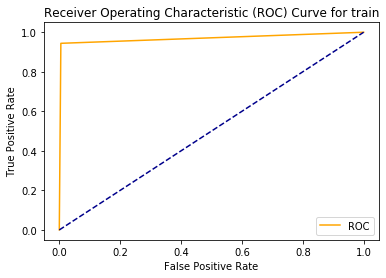

Classification Report tests
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.64      0.80      0.71       375

    accuracy                           0.98     16000
   macro avg       0.82      0.89      0.85     16000
weighted avg       0.99      0.98      0.99     16000

------------------------------------------------
Accuracy Score
0.984875
------------------------------------------------


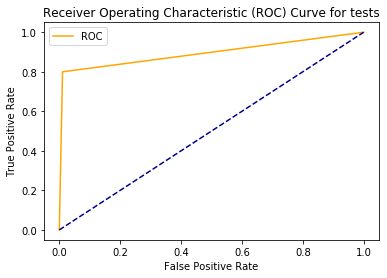

0.984875

In [4]:
from sklearn.model_selection import KFold 
from sklearn.metrics import recall_score
cv = KFold(n_splits=5, random_state=42)
if jvm.started:
    x1=1
else:
    jvm.start(max_heap_size="2048m")
smoter = SMOTE(random_state=42)

eval_dict = {}
X_train = X_train_class
y_train = y_train_class
for train_fold_index, val_fold_index in cv.split(X_train, y_train):
    # Get the training data
    X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

    # Upsample only the data in the training section
    X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                       y_train_fold)

    train_path = './smote_train_fold.csv'
    export_train = pd.concat([y_train_fold_upsample,X_train_fold_upsample],axis=1)
    #print(export_data)
    export_train.to_csv(train_path, sep=',', index=False)
    train_data = converter.load_any_file(filename=train_path)
    train_data.class_is_first()
    
    
    
    log_tree = Classifier(classname="weka.classifiers.trees.LMT")
    eval_obj = Evaluation(train_data)
    
    log_tree.build_classifier(train_data)
    
    
    test_path = './smote_test_fold.csv'
    export_test = pd.concat([y_val_fold,X_val_fold],axis=1)
    export_test.to_csv(test_path, sep=',', index=False)
    test_data = converter.load_any_file(filename=test_path)
    test_data.class_is_first()       
    
    y_test_replaced = y_val_fold.copy()
    y_test_replaced.replace('neg',0,inplace=True)
    y_test_replaced.replace('pos',1,inplace=True)

    y_pred = eval_obj.test_model(log_tree,test_data)
    eval_dict[recall_score(y_pred,y_test_replaced)] = [log_tree,eval_obj]


    
################  TRAIN ERROR #########################    
final_train_path = './smote_train_final.csv'
export_data = pd.concat([y_train_class,X_train_class],axis=1)
#print(export_data)
export_data.to_csv(final_train_path, sep=',', index=False)
final_train = converter.load_any_file(filename=final_train_path)
final_train.class_is_first()

y_test_replaced = y_train_class.copy()
y_test_replaced.replace('neg',0,inplace=True)
y_test_replaced.replace('pos',1,inplace=True)

y_pred_train = eval_dict[max(eval_dict)][1].test_model(eval_dict[max(eval_dict)][0],final_train)

get_class_metrics(y_pred_train,y_test_replaced,'train')  
    
    
    
############## TEST ERROR ###########
    
final_path = './smote_test_final.csv'
export_data = pd.concat([y_test_class,X_test_class],axis=1)
#print(export_data)
export_data.to_csv(final_path, sep=',', index=False)
final_data = converter.load_any_file(filename=final_path)
final_data.class_is_first()

y_test_replaced = y_test_class.copy()
y_test_replaced.replace('neg',0,inplace=True)
y_test_replaced.replace('pos',1,inplace=True)

y_pred_1 = eval_dict[max(eval_dict)][1].test_model(eval_dict[max(eval_dict)][0],final_data)

get_class_metrics(y_pred_1,y_test_replaced,'tests')